[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/j-takemasa/seeds-2025/blob/main/seeds2025_wfattack.ipynb)

# 関数、ライブラリの定義

コードを実行するだけでよい。

In [13]:
#はじめに実行(一回だけ実行すれば良い)
!pip install scapy
# DF model used for non-defended dataset
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, BatchNormalization
from keras.layers import Activation, Flatten, Dense, Dropout, ELU
from keras.initializers import glorot_uniform

import os
import sys
import numpy as np
from scapy.all import rdpcap
import tensorflow as tf
from tqdm import tqdm
import matplotlib.pyplot as plt

def extract_features(packet_file):
    packet_sizes = []
    timestamps = []
    packets = rdpcap(packet_file)
    start_time = None
    cumm_sizes = 0
    for packet in packets:
        if packet.haslayer("IP") and (packet.haslayer("TCP") or packet.haslayer("UDP")):
            if start_time is None:
                start_time = packet.time
            if packet.haslayer("TCP"):
                # packet_sizes.append(len(packet['TCP'].payload))
                cumm_sizes += len(packet['TCP'].payload)
                packet_sizes.append(cumm_sizes)
                timestamps.append(packet.time - start_time)  # 最初のパケットのタイムスタンプからの経過時間を計算
            elif packet.haslayer("UDP") and packet['UDP'].dport == 443:  # QUICの場合
                cumm_sizes += len(packet['UDP'].payload)
                packet_sizes.append(cumm_sizes)
                timestamps.append(packet.time - start_time)  # 最初のパケットのタイムスタンプからの経過時間を計算
    return np.array(packet_sizes), np.array(timestamps)

def create_training_data(max_packet_length,sites,pcap_file_num,pcap_dir):
    data = []
    labels = []
    # global max_packet_length
    print("訓練用データ作成中...")
    for site in sites:
        print(site)
        for i in tqdm(range(0, pcap_file_num)):
            # packet_file = f'{pcap_dir}/output_www_{site}_com_{i}.pcap'
            # packet_file = f'{pcap_dir}/{site}-pcaplist/{site}{i}.pcap'
            packet_file = f'{pcap_dir}/{site}/{i}.pcap'
            packet_sizes, timestamps = extract_features(packet_file)
            # パケットサイズが最大長を超える場合は切り捨て
            if len(packet_sizes) > max_packet_length:
                packet_sizes = packet_sizes[:max_packet_length]
                timestamps = timestamps[:max_packet_length]
            data.append((packet_sizes, timestamps))  # パケットサイズとタイムスタンプをタプルとして保存
            labels.append(site)

    # ゼロパディングを行い、特徴量を作成
    padded_data = []
    for packet_sizes, timestamps in data:
        pad_length = max_packet_length - len(packet_sizes)
        padded_packet_sizes = np.pad(packet_sizes, (0, pad_length), mode='constant')
        padded_timestamps = np.pad(timestamps, (0, pad_length), mode='constant')
        padded_features = np.column_stack((padded_packet_sizes, padded_timestamps))
        padded_data.append(padded_features)

    return np.array(padded_data), np.array(labels)

def convert_to_numeric(data):
    numeric_data = []
    for entry in data:
        numeric_entry = np.array(entry, dtype=np.float32)
        numeric_data.append(numeric_entry)
    return np.array(numeric_data)

#はじめに実行
from google.colab import drive
drive.mount('/content/drive')

pcap_file_num = 30
EPOCHS = 70
max_packet_length = 5000  # 定数値を設定

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 計測したパケット列を Google Drive にアップロードしよう
- GoogleDriveを開き、"seeds-25"というフォルダを作成
- "seeds-25"に移動し、計測したパケット列をここに保存
- 赤い文字でエラーが出たら、教員に申し出ること

In [14]:
!ls /content/drive/MyDrive/seeds-25/dataset
pcap_dir = "/content/drive/MyDrive/seeds-25/dataset"
sites = os.listdir(pcap_dir)
print(sites)

amazonjp  baidu  googlejp  osakau  rakuten
['amazonjp', 'googlejp', 'baidu', 'osakau', 'rakuten']


# 特徴量を抽出し、可視化しょう
- 累積パケットサイズの時系列変化を、特徴量として使います。
- 上述の、各サイト名を sitesの要素として、入力してください。
  - 例: amazon, baidu, googlejp,osakau,rakuten の場合は、以下の通り。適宜、変更してください。


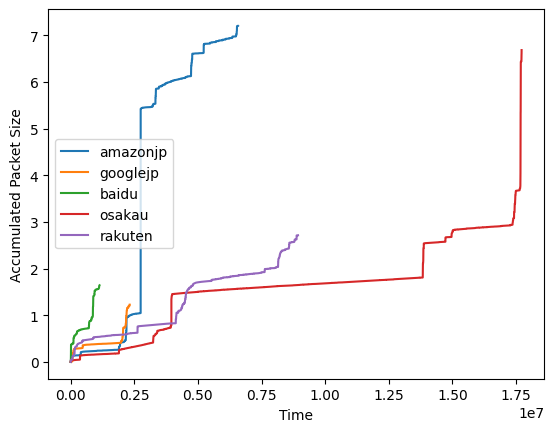

In [10]:
features = {}
for site in sites:
  features[site] = {}
  path = "/content/drive/MyDrive/seeds-25/dataset/"+site+"/0.pcap"
  features[site]["size"], features[site]["timestamp"]  =  extract_features(path)

for site in sites:
  x = features[site]["size"]
  y = features[site]["timestamp"]
  plt.plot(x,y,label=site)

plt.legend()
plt.xlabel("Time")
plt.ylabel("Accumulated Packet Size")

plt.savefig("/content/drive/MyDrive/seeds-25/features_graph.pdf")
plt.savefig("/content/drive/MyDrive/seeds-25/features_graph.png")
plt.show()

# AIモデルの定義
- 今回は、畳み込みニューラルネットワーク (Convolutional Neural Network: CNN)を使います


In [15]:
class DFNet:
    @staticmethod
    def build(input_shape, classes):
        model = Sequential()
        #Block1
        filter_num = ['None',32,64,128,256]
        kernel_size = ['None',8,8,8,8]
        conv_stride_size = ['None',1,1,1,1]
        pool_stride_size = ['None',4,4,4,4]
        pool_size = ['None',8,8,8,8]

        model.add(Conv1D(filters=filter_num[1], kernel_size=kernel_size[1], input_shape=input_shape,
                         strides=conv_stride_size[1], padding='same',
                         name='block1_conv1'))
        model.add(BatchNormalization(axis=-1))
        model.add(ELU(alpha=1.0, name='block1_adv_act1'))
        model.add(Conv1D(filters=filter_num[1], kernel_size=kernel_size[1],
                         strides=conv_stride_size[1], padding='same',
                         name='block1_conv2'))
        model.add(BatchNormalization(axis=-1))
        model.add(ELU(alpha=1.0, name='block1_adv_act2'))
        model.add(MaxPooling1D(pool_size=pool_size[1], strides=pool_stride_size[1],
                               padding='same', name='block1_pool'))
        model.add(Dropout(0.1, name='block1_dropout'))

        model.add(Conv1D(filters=filter_num[2], kernel_size=kernel_size[2],
                         strides=conv_stride_size[2], padding='same',
                         name='block2_conv1'))
        model.add(BatchNormalization())
        model.add(Activation('relu', name='block2_act1'))

        model.add(Conv1D(filters=filter_num[2], kernel_size=kernel_size[2],
                         strides=conv_stride_size[2], padding='same',
                         name='block2_conv2'))
        model.add(BatchNormalization())
        model.add(Activation('relu', name='block2_act2'))
        model.add(MaxPooling1D(pool_size=pool_size[2], strides=pool_stride_size[3],
                               padding='same', name='block2_pool'))
        model.add(Dropout(0.1, name='block2_dropout'))

        model.add(Conv1D(filters=filter_num[3], kernel_size=kernel_size[3],
                         strides=conv_stride_size[3], padding='same',
                         name='block3_conv1'))
        model.add(BatchNormalization())
        model.add(Activation('relu', name='block3_act1'))
        model.add(Conv1D(filters=filter_num[3], kernel_size=kernel_size[3],
                         strides=conv_stride_size[3], padding='same',
                         name='block3_conv2'))
        model.add(BatchNormalization())
        model.add(Activation('relu', name='block3_act2'))
        model.add(MaxPooling1D(pool_size=pool_size[3], strides=pool_stride_size[3],
                               padding='same', name='block3_pool'))
        model.add(Dropout(0.1, name='block3_dropout'))

        model.add(Conv1D(filters=filter_num[4], kernel_size=kernel_size[4],
                         strides=conv_stride_size[4], padding='same',
                         name='block4_conv1'))
        model.add(BatchNormalization())
        model.add(Activation('relu', name='block4_act1'))
        model.add(Conv1D(filters=filter_num[4], kernel_size=kernel_size[4],
                         strides=conv_stride_size[4], padding='same',
                         name='block4_conv2'))
        model.add(BatchNormalization())
        model.add(Activation('relu', name='block4_act2'))
        model.add(MaxPooling1D(pool_size=pool_size[4], strides=pool_stride_size[4],
                               padding='same', name='block4_pool'))
        model.add(Dropout(0.1, name='block4_dropout'))

        model.add(Flatten(name='flatten'))
        model.add(Dense(512, kernel_initializer=glorot_uniform(seed=0), name='fc1'))
        model.add(BatchNormalization())
        model.add(Activation('relu', name='fc1_act'))

        model.add(Dropout(0.7, name='fc1_dropout'))

        model.add(Dense(512, kernel_initializer=glorot_uniform(seed=0), name='fc2'))
        model.add(BatchNormalization())
        model.add(Activation('relu', name='fc2_act'))

        model.add(Dropout(0.5, name='fc2_dropout'))

        model.add(Dense(classes, kernel_initializer=glorot_uniform(seed=0), name='fc3'))
        model.add(Activation('softmax', name="softmax"))
        return model

# AIモデルの訓練用データを作成しよう

In [16]:
# scapyによる特徴量抽出(一回だけ実行すれば良い)
# 学習データとラベルを取得
training_data, labels = create_training_data(max_packet_length,sites,pcap_file_num,pcap_dir)
# training_data, labels = create_training_data()
print()
print(training_data.shape)
print(labels.shape)
numeric_training_data = convert_to_numeric(training_data)

訓練用データ作成中...
amazonjp


100%|██████████| 30/30 [00:36<00:00,  1.20s/it]


googlejp


100%|██████████| 30/30 [00:27<00:00,  1.10it/s]


baidu


100%|██████████| 30/30 [00:25<00:00,  1.16it/s]


osakau


100%|██████████| 30/30 [01:27<00:00,  2.93s/it]


rakuten


100%|██████████| 30/30 [00:53<00:00,  1.78s/it]



(150, 5000, 2)
(150,)


# AIモデルを訓練しよう
- 今回は、全データのうち、80%を訓練用に、残りの20%をテスト用に利用します

In [17]:
# TensorFlowモデルの学習
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.utils import to_categorical

# ラベルを数値にエンコード
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# データの前処理
X_train, X_test, y_train, y_test = train_test_split(numeric_training_data, encoded_labels, test_size=0.2, random_state=42, stratify=encoded_labels)

# ラベルをone-hotエンコーディング
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

from keras.optimizers import Adamax

INPUT_SHAPE = (max_packet_length,2)
NB_CLASSES = len(sites)
OPTIMIZER = tf.keras.optimizers.Adamax(learning_rate=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-08) # Optimizer

# モデルの構築
model = DFNet.build(input_shape=INPUT_SHAPE, classes=NB_CLASSES)
model.compile(loss="categorical_crossentropy", optimizer=OPTIMIZER, metrics=["accuracy"])
print ("Model compiled")

print(X_train.shape)
print(y_train_cat.shape)

# モデルの学習
model.fit(X_train, y_train_cat, epochs=EPOCHS, batch_size=32, validation_data=(X_test, y_test_cat))

# モデルの評価
loss, accuracy = model.evaluate(X_test, y_test_cat)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model compiled
(120, 5000, 2)
(120, 5)
Epoch 1/70
4/4 ━━━━━━━━━━━━━━━━━━━━ 41s 5s/step - accuracy: 0.2800 - loss: 2.3731 - val_accuracy: 0.6000 - val_loss: 8.2615
Epoch 2/70
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 68ms/step - accuracy: 0.6590 - loss: 0.7934 - val_accuracy: 0.7667 - val_loss: 18.5260
Epoch 3/70
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.8148 - loss: 0.4514 - val_accuracy: 0.7667 - val_loss: 20.3470
Epoch 4/70
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.8931 - loss: 0.3337 - val_accuracy: 0.7667 - val_loss: 17.3095
Epoch 5/70
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9327 - loss: 0.2981 - val_accuracy: 0.7667 - val_loss: 15.0574
Epoch 6/70
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9627 - loss: 0.2056 - val_accuracy: 0.7667 - val_loss: 12.8179
Epoch 7/70
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9767 - loss: 0.0870 - val_accuracy: 0.8000 - val_loss: 10.2341
Epoch 8/70
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9625 - loss: 0.18

# 分類精度を計測しよう
- 訓練に使わなかった、20%のデータを用いて、正しく分類できているかをテストします
- 制度の指標には、正解率 (Accuracy)を利用します。
  - **Accuracy**: 全データのうち、正しく分類されたデータの割合。正しいとは、分類結果と、そのサイト名 (ラベル)が一致することを指す。

In [18]:
predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)
actual_labels = np.argmax(y_test_cat, axis=1)

# 予測結果と実際のラベルを表示
predicted_sites = label_encoder.inverse_transform(predicted_labels)
actual_sites = label_encoder.inverse_transform(actual_labels)

# 全ての結果（分類器の予測結果と正しいサイト名の組み合わせ）を表示
"""
for i in range(len(X_test)):
    print(f'Index: {i}')
    print(f'Actual site: {actual_sites[i]}')
    print(f'Predicted site: {predicted_sites[i]}')
    print('---')
"""

import pandas as pd
# 予測結果と実際のラベルをデータフレームに変換
results = pd.DataFrame({
    'Actual site': actual_sites,
    'Predicted site': predicted_sites
})

# 結果をCSVファイルに保存（index=Falseでインデックスを省略）
results.to_csv('results.csv', index=False)

print("---Results---")

# 各サイトのラベルを取得
unique_sites = label_encoder.classes_

# サイトごとの正答率を計算
correct_counts = {site: 0 for site in unique_sites}
total_counts = {site: 0 for site in unique_sites}

for actual, predicted in zip(actual_sites, predicted_sites):
    total_counts[actual] += 1
    if actual == predicted:
        correct_counts[actual] += 1

accuracy_per_site = {site: correct_counts[site] / total_counts[site] for site in unique_sites}

# 正答率を表示
for site, accuracy in accuracy_per_site.items():
    print(f'Site: {site}, Accuracy: {accuracy:.2f}')

from collections import defaultdict

# 間違えた場合の集計
misclassification_counts = {site: defaultdict(int) for site in unique_sites}

for actual, predicted in zip(actual_sites, predicted_sites):
    if actual != predicted:
        misclassification_counts[actual][predicted] += 1

# 各サイトごとに間違えた他サイトの割合を計算
misclassification_ratios = {}

for site in unique_sites:
    total_misclassifications = sum(misclassification_counts[site].values())
    if total_misclassifications > 0:
        misclassification_ratios[site] = {predicted: count / total_misclassifications for predicted, count in misclassification_counts[site].items()}
    else:
        misclassification_ratios[site] = {}
print("---Misclassified---")
# 結果を表示
for site, ratios in misclassification_ratios.items():
    print(f'Site: {site}')
    for misclassified_site, ratio in ratios.items():
        print(f'  Misclassified as {misclassified_site}: {ratio:.2f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
---Results---
Site: amazonjp, Accuracy: 1.00
Site: baidu, Accuracy: 1.00
Site: googlejp, Accuracy: 1.00
Site: osakau, Accuracy: 0.00
Site: rakuten, Accuracy: 1.00
---Misclassified---
Site: amazonjp
Site: baidu
Site: googlejp
Site: osakau
  Misclassified as rakuten: 1.00
Site: rakuten


# **成果をレポートにまとめよう**

- パケット列の特徴量の計測結果
  - 各ウェブサイトの特徴量のグラフ
- ウェブサイト毎の特徴量に関する考察
  - 異なるウェブサイトで、特徴量に差異があるか・ないか
  - なぜ、差異が生じるのか・生じないのか、の理由
- ウェブサイトの分類精度の計測結果
  - テストデータを用いて計測した Accuracy の結果を、ウェブサイト毎にまとめよう
- ウェブサイトの分類精度の結果に関する考察
  - 正しく分類できた・できなかった
  - その理由
- ウェブページの分類に関する考察 (時間に余裕がある人だけで良い)
  - ウェブサイトとウェブページの分類について、気づいた違いについて述べよ

# **パケット列の特徴量の計測結果**

- 上部で出力したグラフを右クリックでコピーして来る
- 以下の空欄をクリックし、キー"Ctrl+V"を押して貼り付け


## ウェブサイト毎の特徴量に関する考察
(**ダブルクリックし、以下に記入してください**)


## ウェブサイトの分類精度の計測結果
(**ダブルクリックし、以下に記入してください**)



## ウェブサイトの分類精度の結果に関する考察
(**ダブルクリックし、以下に記入してください**)



# ウェブページの分類に関する考察 (時間に余裕がある人だけで良い)
(**ダブルクリックし、以下に記入してください**)

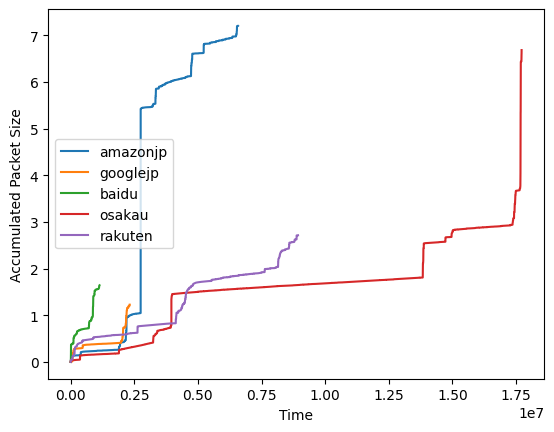